In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


## 1. 准备并处理数据

In [2]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.data.shape)
print(housing.target.shape)

(20640, 8)
(20640,)


In [3]:
import pprint

pprint.pprint(housing.data[0:5])
pprint.pprint(housing.target[0:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


In [4]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, 
                                                            random_state= 7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, 
                                                      random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

## 2. **模型构建（子类API）**

In [6]:
class WideDeepModel(keras.models.Model):
    def __init__(self):
        super(WideDeepModel, self).__init__()
        """定义模型的层次"""
        self.hidden1_layer = keras.layers.Dense(30, activation="relu")
        self.hidden2_layer = keras.layers.Dense(30, activation="relu")
        self.output_layer = keras.layers.Dense(1)
        
    def call(self, input):
        """完成模型的正向计算"""
        hidden1 = self.hidden1_layer(input)
        hidden2 = self.hidden2_layer(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_layer(concat)
        return output
# 两种使用方法
# 方法一
model = WideDeepModel()
# 方法二
# model = keras.models.Sequential([ WideDeepModel()])

model.build(input_shape=(None, 8))    # 两种方法都需要这一步

    
model.summary()
model.compile(loss="mean_squared_error", optimizer="Adam")
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]

Model: "wide_deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  270       
_________________________________________________________________
dense_1 (Dense)              multiple                  930       
_________________________________________________________________
dense_2 (Dense)              multiple                  39        
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


## 3. 训练模型

In [7]:
history = model.fit(x_train_scaled, y_train, 
                   validation_data = (x_valid_scaled, y_valid),
                   epochs = 100,
                   callbacks = callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 80us/sample - loss: 1.1481 - val_loss: 0.5858
Epoch 2/100
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4839 - val_loss: 0.4496
Epoch 3/100
11610/11610 [==============================] - 0s 37us/sample - loss: 0.4053 - val_loss: 0.4023
Epoch 4/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.3783 - val_loss: 0.3835
Epoch 5/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.3704 - val_loss: 0.3684
Epoch 6/100
11610/11610 [==============================] - 0s 38us/sample - loss: 0.3514 - val_loss: 0.3572
Epoch 7/100
11610/11610 [==============================] - 0s 38us/sample - loss: 0.3445 - val_loss: 0.3600
Epoch 8/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.3387 - val_loss: 0.3474
Epoch 9/100
11610/11610 [==============================] - 0s 38us/sample - loss: 0.326

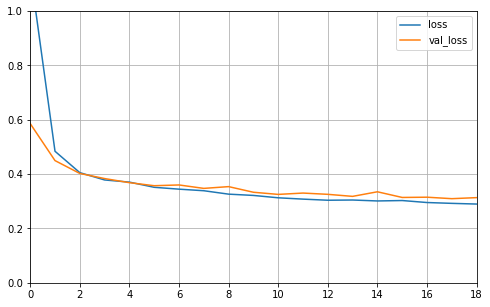

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

## 4. 模型预测

In [9]:
model.evaluate(x_test_scaled, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.33159469707991723